In [1]:
# Regression example-1 for ENGR400
# Prepared by Dr. Raju Gottumukkala

import pandas as pd # Python module to work with tabular data
import numpy as np # Python module which supports MATLAB like matrix operation
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso # Linear Regression, Stocastic Gradient Decent
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error # Python modules to calculate different error metrics


from matplotlib import pyplot as plt # Python plotting functions
import seaborn as sns # Special purpose plotting function
import statistics

In [9]:
#set plotting format to be used later
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D 
import matplotlib as mpl

%matplotlib inline 
mpl.rcParams['font.size']=10
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['axes.titlesize']=10
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=0.5)

In [3]:
# These are subfunctions to calculate rolling average of mean and standard deviation for  window length 'w'
#df is the data frame, col is the feature, and w is the window length
def rollm(df, w, col):
    return df[col].rolling(w).mean().shift(1)

def rolls(df, w, col):
    return df[col].rolling(w).std().shift(1)

In [4]:
#STEP 0a: Read data
# Here we are reading data and asking python to index the column as a date
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

df = pd.read_csv('TSLA.csv',index_col=0,parse_dates=["Date"])

#print(df.to_string())
print(df.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-12-29  15.126667  15.194000  14.934667  15.047333  15.047333  42037500
2014-12-30  14.932667  15.043333  14.760000  14.815333  14.815333  43548000
2014-12-31  14.872667  15.045333  14.816667  14.827333  14.827333  34462500
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500


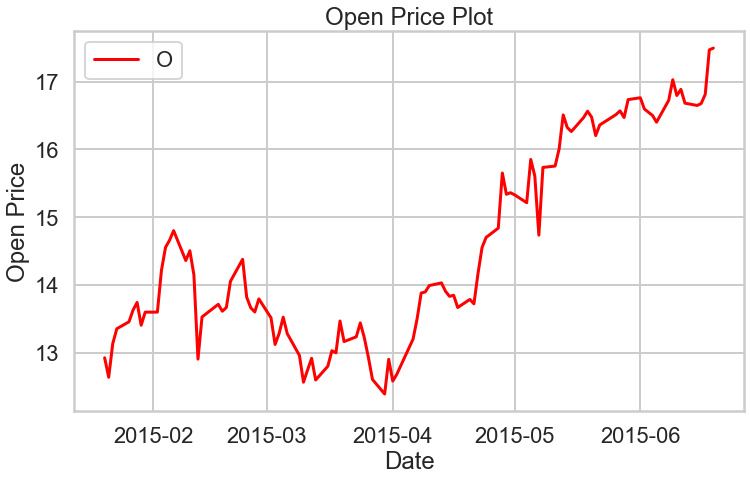

In [5]:
# STEP 0b: Understand data

# Note that the time series is between a certain range
# the df.loc allows you to select a range of data

df2 =df.loc["2015-1-20":"2015-6-21"]

# plot
plt.plot(df2.index,df2.Open, color='red')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open Price Plot')
plt.legend("Open")
plt.show()
#plt.plot(df2)


In [6]:
# step1: Data pre-processing
data = df.dropna(axis=0)
df.size

11634

In [7]:
# step 2a: Feature extraction/computation

#data = generate_new_features(df)
 # We will store the new features in this dataframe

df_new = pd.DataFrame()
df_new['open'] = df['Open']

# Previous day variables (note the shift operator)

df_new['open_1'] = df['Open'].shift(1)
df_new['close_1'] = df['Close'].shift(1)
df_new['high_1'] = df['High'].shift(1)
df_new['low_1'] = df['Low'].shift(1)
df_new['volume_1'] = df['Volume'].shift(1)

# avergae price
df_new['avg_price_5'] = rollm(df, 5, 'Open')
df_new['avg_price_30'] = rollm(df, 21, 'Open') 
df_new['avg_price_365'] = rollm(df, 252, 'Open')

# the goal is to predict the target variable

# CHANGE TO OPEN PRICE OF THE NEXT DAY , USE SHIFT(-1) TO LOOK AHEAD ------------------------------------
df_new['open_nd'] = df['Open'].shift(-1)

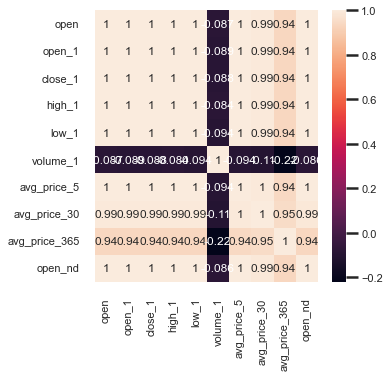

In [10]:
# Note that we will have some null values and nan, we have to clearn them

#check how many nan values
df_new.isnull().sum().sum()

#drop all the naans and round data to 3 digits
data = df_new.dropna(axis=0)
data = df_new.round(decimals=3)

#Pearson Correlation to eliminate variables
plt.figure(figsize=(5, 5))
cor = data.corr()

#Using heatmap function from seaborne
sns.heatmap(cor, annot=True)
plt.show()

In [12]:
# step 2b
# let us take only two features into the feature table 'ft'

ft = pd.DataFrame()
ft['MA_5day']=  data['avg_price_5']
ft['MA_30day'] = data['avg_price_30']

#ADD TWO MORE FEATURES - PREVIOUS DAY CLOSING PRICE AND ROLL MEAN OF STD DEV OF VOLUME FOR PAST 5 DAYS ----------
ft['close_1'] = df['Close'].shift(1)
ft['std_rollm5'] = rolls(data, 5, 'volume_1')

#INCLUDE OUR TARGET
ft['open_nd'] = data['open_nd']
len_idx = len(data.index)
print(len_idx)

#drop all the naans and round data to 3 digits
ft = ft.dropna(axis=0)
t = ft.round(decimals=3)

ft
# ft.iloc[1:5,1]
#ft.shape[0]
#ft.iloc[:,3]

1939


,MA_5day,MA_30day,close_1,std_rollm5,open_nd
Date,,,,,
2015-01-29,13.462,13.737,13.291333,8.836517e+06,13.597
2015-01-30,13.516,13.655,13.680000,7.398339e+06,13.598
2015-02-02,13.565,13.591,13.573333,4.454686e+06,14.215
2015-02-03,13.594,13.530,14.062667,4.256251e+06,14.553
2015-02-04,13.711,13.500,14.557333,8.066893e+06,14.659
...,...,...,...,...,...
2022-09-01,290.222,297.183,275.609985,6.338261e+06,281.070
2022-09-02,284.266,295.640,277.160004,5.653641e+06,272.680
2022-09-06,280.994,294.214,270.209991,5.777146e+06,273.100


In [13]:
# step 3a: Split dataset into 70-30 split
X_train, X_test, y_train, y_test = train_test_split(ft.iloc[:,0:4],ft.iloc[:,-1],test_size=0.3,shuffle=False)

print("Training set size=",X_train.shape[0], "Testing set size=",X_test.shape[0])

Training set size= 1341 Testing set size= 576


In [23]:
#step 3b: Fit the Linear Regression Model & Calculate Error Metrics
regr = LinearRegression() 
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test) 

MAE_linear=mean_absolute_error(y_test, y_pred)
MSE_linear=mean_squared_error(y_test, y_pred)
MAPE_linear=mean_absolute_percentage_error(y_test, y_pred)
r_linear = np.corrcoef(y_test, y_pred)[1][0]

In [24]:
#step 3c: Fit Ridge Regression Model & Calculate Error Metrics
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_test_rr= rr.predict(X_test)

MAE_ridge=mean_absolute_error(y_test, pred_test_rr)
MSE_ridge=mean_squared_error(y_test, pred_test_rr)
MAPE_ridge=mean_absolute_percentage_error(y_test, pred_test_rr)
r_ridge = np.corrcoef(y_test, pred_test_rr)[1][0]

In [25]:
#step 3d: Fit Lasso Regression Model & Calculate Error Metrics
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_test_lasso= model_lasso.predict(X_test)

MAE_lasso=mean_absolute_error(y_test, pred_test_lasso)
MSE_lasso=mean_squared_error(y_test, pred_test_lasso)
MAPE_lasso=mean_absolute_percentage_error(y_test, pred_test_lasso)
r_lasso = np.corrcoef(y_test, pred_test_lasso)[1][0]

In [26]:
#display many decimals to see differences in error values
pd.set_option('display.float_format', '{:.10f}'.format)
error = {
    'MAE' : [MAE_linear, MAE_ridge, MAE_lasso],
    'MSE' : [MSE_linear, MSE_ridge, MSE_lasso],
    'MAPE' : [MAPE_linear, MAPE_ridge, MAPE_lasso],
    'R'   : [r_linear,r_ridge,r_lasso]
}
error = pd.DataFrame.from_dict(error)
error.index = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
error


,MAE,MSE,MAPE,R
Linear Regression,8.1203037963,126.4140582976,0.0355944407,0.9900872575
Ridge Regression,8.1203039183,126.4140685605,0.0355944429,0.9900872600
Lasso Regression,8.1120823866,126.1777578781,0.0355624653,0.9900949304


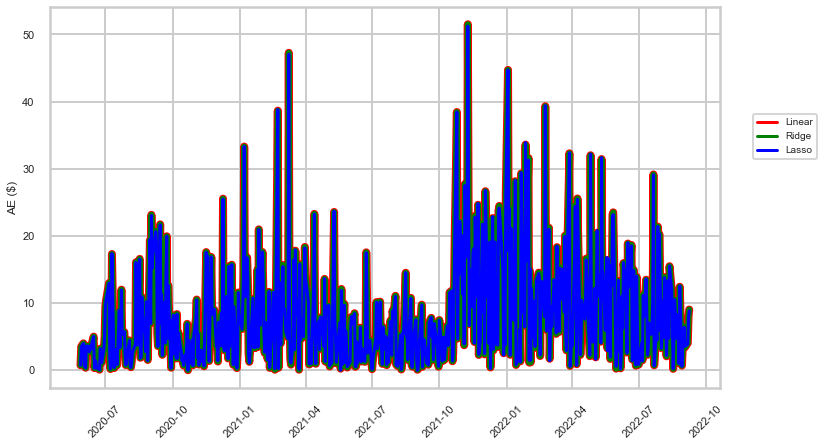

In [64]:
ae_rr = abs(y_test - pred_test_rr)
ae_lasso = abs(pred_test_lasso - y_test)
ae_linear = abs(y_pred - y_test)

#plot results
x = ae_rr.index
y = ae_linear
plt.plot(x,y,c='red', linewidth=8)
y = ae_rr
plt.plot(x, y, c='green', linewidth=6)
y = ae_lasso
plt.plot(x, y,c='blue', linewidth=3)
plt.ylabel('AE ($)')
# plt.xlabel('Time')
plt.xticks(rotation = 45)


#generate legend
line_1 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='Linear')
line_2 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='Ridge')
line_3 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='Lasso')
lines = [line_1, line_2, line_3]
plt.legend(prop=dict(size='small'), loc=[1.05, 0.6],handles=lines)

Text(0.5, 1.0, 'Distribution plot of Error - Lasso Regression')

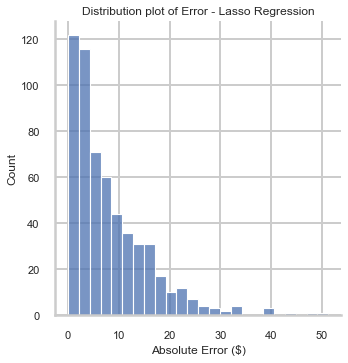

In [67]:
#check distributions just to be aware
sns.displot(ae_lasso)
plt.xlabel('Absolute Error ($)')
plt.title('Distribution plot of Error - Lasso Regression')